In [1]:
!pip install gdown

In [2]:
import numpy as np 
import pandas as pd
import matplotlib as pltlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm
!pip install -q torchsummary

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Evalaution Metrics Functions

Pixel Accuracy

In [3]:
def test_pixel_accuracy(model, test_set):
    score_accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_pixel_accuracy(model, img, mask)
        score_accuracy.append(score)  # Append the dice score as a scalar value
    num_acc_scores = len(score_accuracy)
    total_acc_score = sum(score_accuracy)
    average_acc_score = total_acc_score / num_acc_scores
    return average_acc_score


def predict_pixel_accuracy(model, image, mask):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc_score = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc_score

# Calculate pixel accuracy over a batch of images
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

F1 Score

In [4]:
def test_f1_score(model, test_set):
    score_f1 = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_f1_score(model, img, mask)
        score_f1.append(score.item())  # Append the dice score as a scalar value
    num_f1_scores = len(score_f1)
    total_f1_score = sum(score_f1)
    average_f1_score = total_f1_score / num_f1_scores
    return average_f1_score


def predict_f1_score(model, image, mask):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        f1_scores = f1_Scores(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, f1_scores

# Calculate f1 score
def f1_Scores(output, mask):
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        true_positives = torch.sum(torch.round(torch.clamp(output * mask, 0, 1)))
        actual_positives = torch.sum(torch.round(torch.clamp(mask, 0, 1)))
        predicted_positives = torch.sum(torch.round(torch.clamp(output, 0, 1)))


        precision = true_positives / (predicted_positives + 1e-7)
        recall = true_positives / (actual_positives + 1e-7)
        f1_sco = 2 * (precision * recall) / (precision + recall + 1e-7)
    return f1_sco

Specificity

In [5]:
def test_specificity(model, test_set):
    score_spec = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_specificity(model, img, mask)
        score_spec.append(score.item())  # Append the dice score as a scalar value
    num_spec_scores = len(score_spec)
    total_spec_score = sum(score_spec)
    average_spec_score = total_spec_score / num_spec_scores
    return average_spec_score


def predict_specificity(model, image, mask):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        spec_score = specificity(output, mask)
        spec_score = torch.sum(spec_score) 
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, spec_score

def specificity(output, mask):
    '''output = torch.argmax(output, dim=1)
    true_negatives = torch.sum((1 - mask) * (1 - output))
    possible_negatives = torch.sum(1-mask)
    speci = true_negatives / (possible_negatives + 1e-7)
    return speci.mean()'''
    output = torch.argmax(output, dim=1)
    true_negatives = torch.sum(torch.round(torch.clamp((1 - mask) * (1 - output), 0, 1)))
    possible_negatives = torch.sum(torch.round(torch.clamp(1 - mask, 0, 1)))
    speci = torch.sum(torch.round(torch.clamp(true_negatives / (possible_negatives + torch.finfo(torch.float32).eps), 0, 1)))
    return speci


Sensitivity

In [6]:
def test_sensitivity(model, test_set):
    score_sensi = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_sensitivity(model, img, mask)
        score_sensi.append(score.item())  # Append the dice score as a scalar value
    num_sensi_scores = len(score_sensi)
    total_sensi_score = sum(score_sensi)
    average_sensi_score = total_sensi_score / num_sensi_scores
    return average_sensi_score


def predict_sensitivity(model, image, mask):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        sensi_score = sensitivity(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, sensi_score

def sensitivity(output, mask):
    output = torch.argmax(output, dim=1)
    true_positives = torch.sum(torch.round(torch.clamp(output * mask, 0, 1)))
    possible_positives = torch.sum(torch.round(torch.clamp(mask, 0, 1)))
    return true_positives / (possible_positives + torch.finfo(torch.float32).eps)



MIOU - Mean Intersection over Union

In [7]:
def test_miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

# Calculate mean Intersection-over-Union over a batch of images
def mIoU(pred_mask, mask, smooth=1e-10,n_classes=12):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)
    
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

Dice

In [8]:
def test_dice_coefficient(model, test_set):
    score_dice = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_dice(model, img, mask)
        score_dice.append(score.item())  # Append the dice score as a scalar value
    num_dice_scores = len(score_dice)
    total_dice_score = sum(score_dice)
    average_dice_score = total_dice_score / num_dice_scores
    return average_dice_score


def predict_image_mask_dice(model, image, mask):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        dice_score = dice_coeff(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, dice_score

def dice_coeff(output, mask):
    intersection = torch.sum(torch.round(torch.clamp(output * mask, 0, 1)))
    union = torch.sum(torch.round(torch.clamp(output, 0, 1)))+torch.sum(torch.round(torch.clamp(mask, 0, 1)))
    
    dice_score = torch.clamp((2.0 * intersection + torch.finfo(torch.float32).eps) / (union + torch.finfo(torch.float32).eps),0,1)

    return dice_score

Display Image for Comaprison of Mask

In [9]:
def display_for_comparison(image, mask, pred_mask):

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
    ax1.imshow(image)
    ax1.set_title('Picture');

    ax2.imshow(mask)
    ax2.set_title('Ground truth')
    ax2.set_axis_off()

    ax3.imshow(pred_mask)
    ax3.set_title('UNet-EfficientNet-v6 | mIoU {:.3f}'.format(score))
    ax3.set_axis_off()

In [10]:
def display_for_comparison_with_image(image,mask, pred_mask):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    
    ax1.imshow(image, cmap = 'viridis')
    ax1.set_title('Image with Mask')
    ax1.imshow(mask, alpha=0.6, cmap ='viridis')
    ax1.set_axis_off()

    # Add a colorbar to show the mapping between colors and data values
    plt.colorbar(msk)
    
    ax2.imshow(image, cmap = 'viridis')
    ax2.imshow(pred_mask, alpha=0.6, cmap ='viridis')
    ax2.set_title('Image with Predicted Mask')
    ax2.set_axis_off()
    #ax2.colorbar(msk)

# Data Loading

In [11]:
#this functionis purly for kaggle notebook
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)

In [12]:
#downloading the dataset from googledrive
!gdown --id 1RfYynXLo-BUJahcCzlZu6fAghidK26oO

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1RfYynXLo-BUJahcCzlZu6fAghidK26oO
From (redirected): https://drive.google.com/uc?id=1RfYynXLo-BUJahcCzlZu6fAghidK26oO&confirm=t&uuid=a7bed794-f806-47df-a730-56dc4b9bcf1a
To: /kaggle/working/A3_Dataset.zip
100%|█████████████████████████████████████████| 126M/126M [00:01<00:00, 102MB/s]


In [13]:
#unzipping the dataset
!unzip /kaggle/working/A3_Dataset.zip;

Archive:  /kaggle/working/A3_Dataset.zip
   creating: A3_Dataset/
   creating: A3_Dataset/dataset1/
   creating: A3_Dataset/dataset1/annotations_prepped_test/
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07959.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07961.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07963.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07965.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07967.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07969.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07971.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07973.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07975.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07977.png  
  inflating: A3_Dataset/dataset1/annotations_prepped_test/0016E5_07979.

In [14]:
#defining paths
IMAGE_PATH_TRAIN = "A3_Dataset/dataset1/images_prepped_train/"
MASK_PATH_TRAIN = "A3_Dataset/dataset1/annotations_prepped_train/"
IMAGE_PATH_TEST = "A3_Dataset/dataset1/images_prepped_test/"
MASK_PATH_TEST = "A3_Dataset/dataset1/annotations_prepped_test/"

In [15]:
#creating dataframe of taining and testing set
n_classes = 12 

def create_df(IMAGE_PATH):
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df_train = create_df(IMAGE_PATH_TRAIN)
df_test = create_df(IMAGE_PATH_TEST)
print('Training Images: ', len(df_train))
print('Testing Images: ' ,len(df_test))

Training Images:  367
Testing Images:  101


In [16]:
#splitting the training set into training 80% and validation 20%
x_train, x_val = train_test_split(df_train['id'].values, test_size=0.2)

print('Train Size   : ', len(x_train))
print('Val Size     : ', len(x_val))
print('Test Size    : ', len(df_test))

Train Size   :  293
Val Size     :  74
Test Size    :  101


In [17]:
print(pltlib.rcParams['image.cmap'])

viridis


# Display Image from Dataset

Image Size (360, 480, 3)
Mask Size (360, 480)


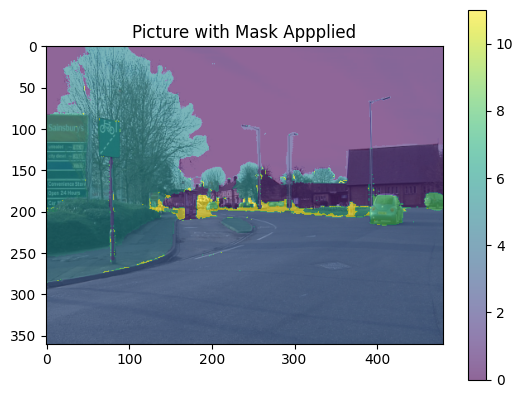

In [18]:
#display and image from the dataset to have a better idea what the dataset is like
img = Image.open(IMAGE_PATH_TRAIN + '/' + df_train['id'][8] + '.png')
mask = Image.open(MASK_PATH_TRAIN + '/' + df_train['id'][8] + '.png')

print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img, cmap = 'viridis')
msk = plt.imshow(mask, alpha=0.6, cmap ='viridis')
plt.title('Picture with Mask Appplied')
#plt.show()

# Add a colorbar to show the mapping between colors and data values
plt.colorbar(msk)

# Show the plot
plt.show()

# Data Preprocessing

In [19]:
#defining image augmentation techniques and paths for training, testing and validation dataset
class Dataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):

        img = cv2.imread(self.img_path + self.X[idx]+ '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
            
        return img, mask
    
    
class TestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


In [20]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)])

t_test = A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)

x_test = df_test['id'].values

#datasets
train_set = Dataset(IMAGE_PATH_TRAIN, MASK_PATH_TRAIN, x_train, mean, std, t_train)
val_set = Dataset(IMAGE_PATH_TRAIN, MASK_PATH_TRAIN, x_val, mean, std, t_val)
test_set = TestDataset(IMAGE_PATH_TEST, MASK_PATH_TEST, x_test, transform=t_test)

#dataloader
batch_size= 8 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

# Initializing Model - UNET with EfficientNet-b6 Backbone

In [21]:
!pip install -q segmentation-models-pytorch
import segmentation_models_pytorch as smp

activation = 'sigmoid' if n_classes == 1 else 'softmax'
model = smp.Unet('efficientnet-b6', encoder_weights='imagenet', classes=n_classes, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth
100%|██████████| 165M/165M [00:01<00:00, 132MB/s] 


Defining Optimizer and Loss Function

In [22]:
# Select a loss function
loss_function = torch.nn.BinaryCrossEntropyLoss() if n_classes==1 else torch.nn.CrossEntropyLoss()

# Select an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
# For more on schedulers please visit:
# https://towardsdatascience.com/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863

# Set the number of epochs
# This variable is used in the main training loop
epochs = 150

model.to(device);

# Training the Model

In [23]:
# Inner loop for running the model for 1 epoch over a given loader

def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):

    if train:
        model.train()
    else:
        model.eval()


    total_correct_preds = 0
    total_loss = 0

    # Number of images we can get by the loader
    total_samples_in_loader = len(loader.dataset)
  
    # number of batches we can get by the loader 
    total_batches_in_loader = len(loader)

    for image_batch, labels in tqdm(loader):
        #converting ndarray to tensor for the .to() function to work
        #image_batch = torch.tensor(image_batch)
        #labels = torch.tensor(labels)
        # Transfer image_batch to GPU if available
        image_batch = image_batch.to(device)
        labels = labels.to(device)

        # Zeroing out the gradients for parameters
        if train:
            assert optimizer is not None, "Optimizer must be provided if train=True"
            optimizer.zero_grad()
    
        # Forward pass on the input batch
        output = model(image_batch)

        # Acquire predicted class indices
        _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows 
    
        # Removing extra last dimension from output tensor
        #output.squeeze_(-1)

        # Compute the loss for the minibatch
        loss = loss_function(output, labels)
    
        # Backpropagation
        if train:
            loss.backward()
    
        # Update the parameters using the gradients
        if train:
            optimizer.step()
    
        # Extra variables for calculating loss and accuracy
        # count total predictions for accuracy calcutuon for this epoch
        #total_correct_preds += (predicted == labels).sum().item()

        total_loss += loss.item()
    
    loss = total_loss / total_batches_in_loader
    accuracy = pixel_accuracy(output, labels)
    mean_IoU = mIoU(output, labels)
    #specificity_score,sensitivity_score= sensitivity_specificity(labels,output)
    specificity_score = specificity(output, labels)
    sensitivity_score = sensitivity(output, labels)


    return loss, accuracy, mean_IoU, specificity_score,sensitivity_score

In [24]:
# Initializing variables for starting a new training
# Some helper variables

train_accuracies = []
val_accuracies = []

train_losses = []
val_losses = []

train_mIoUs = []
val_mIoUs = []

val_mIoU_max = -1

train_specificitys = []
train_sensitivitys = []
val_specificitys = []
val_sensitivitys = []

checkpoint_path = '/kaggle/working/checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint_path = '/kaggle/working/best_val_checkpoint_norm_aug_tensorboard.pth'

# Start epoch is zero for new training
start_epoch = 0

In [25]:
###### Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

    # Train model for one epoch

    # Get the current learning rate from the optimizer
    #print(optimizer.param_groups[0]['lr'])
    current_lr = optimizer.param_groups[0]['lr']

    print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
    train_loss, train_accuracy, train_mIoU,train_specificity, train_sensitivity= run_1_epoch(model, loss_function, train_loader, optimizer, train= True)

    # Update the learning rate scheduler
    scheduler.step()

    # Lists for train loss and accuracy for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_mIoUs.append(train_mIoU)
    train_specificitys.append(train_specificity)
    train_sensitivitys.append(train_sensitivity)

    # Validate the model on validation set
    print("Epoch %d: Validation"%(epoch))
    with torch.no_grad():
        val_loss, val_accuracy, val_mIoU, val_specificity,val_sensitivity  = run_1_epoch(model, loss_function, val_loader, optimizer, train= False)
  
    # Lists for val loss and accuracy for plotting
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_mIoUs.append(val_mIoU)
    val_specificitys.append(val_specificity)
    val_sensitivitys.append(val_sensitivity)

    # The "add_scalar" function adds a new metric to the tensorboard log
    # It is gnerally given 3 arguments:
    # tag: Name of the metric
    # scalar_value = the value of the metric to record
    # global_step = on which milestone to record the scalar value which in our
    # case is the epoch
    # writer.add_scalar(tag = "Loss/train", scalar_value = train_loss, global_step = epoch)
    # writer.add_scalar(tag = "accuracy/train", scalar_value = train_accuracy, global_step = epoch)

    # writer.add_scalar(tag = "Loss/val", scalar_value = val_loss, global_step = epoch)
    # writer.add_scalar(tag = "accuracy/val", scalar_value = val_accuracy, global_step = epoch)

    print('train loss: %.4f'%(train_loss))
    print('val loss: %.4f'%(val_loss))
    
    print('train_accuracy %.2f' % (train_accuracy))
    print('val_accuracy %.2f' % (val_accuracy))
    
    print('train_specificity %.2f'%(train_specificity))
    print('val_specificity %.2f'%(val_specificity))
    
    print('train_sensitivity %.2f'%(train_sensitivity))
    print('val_sensitivity %.2f'%(val_sensitivity))
    
    print('train_IoU %.2f'%(train_mIoU))
    print('val_IoU %.2f'%(val_mIoU))

  
  # Save model if validation accuracy for current epoch is greater than 
  # all the previous epochs 
    if val_mIoU > val_mIoU_max:
        val_mIoU_max = val_mIoU
        print("New max val mean IoU Acheived %.2f. Saving model.\n\n"%(val_mIoU_max))

        checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'trianed_epochs': epoch,
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'train_mIoUs': train_mIoUs,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'val_accuracy_max': val_mIoU_max,
            'val_mIoUs': val_mIoUs,
            'lr': optimizer.param_groups[0]['lr'],
            'specificity': train_specificity,
            'sensitivity': train_sensitivity
            }
        torch.save(checkpoint, best_val_checkpoint_path)

    else:
        print("val mean IoU did not increase from %.2f\n\n"%(val_mIoU_max))
    # Save checkpoint for the last epoch
        checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'trianed_epochs': epoch,
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'train_mIoUs': train_mIoUs,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'val_accuracy_max': val_mIoU_max,
            'val_mIoUs': val_mIoUs,
            'lr': optimizer.param_groups[0]['lr'],
            'specificity': train_specificity,
            'sensitivity': train_sensitivity
            }

    torch.save(checkpoint, checkpoint_path)

Epoch 0: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 0: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 1.2980
val loss: 0.9091
train_accuracy 0.78
val_accuracy 0.82
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.28
val_IoU 0.28
New max val mean IoU Acheived 0.28. Saving model.


Epoch 1: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.6673
val loss: 0.5919
train_accuracy 0.82
val_accuracy 0.81
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.33
val_IoU 0.33
New max val mean IoU Acheived 0.33. Saving model.


Epoch 2: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.5565
val loss: 0.4961
train_accuracy 0.90
val_accuracy 0.86
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.39
val_IoU 0.41
New max val mean IoU Acheived 0.41. Saving model.


Epoch 3: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.4964
val loss: 0.4687
train_accuracy 0.85
val_accuracy 0.90
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.36
val_IoU 0.42
New max val mean IoU Acheived 0.42. Saving model.


Epoch 4: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.4611
val loss: 0.4723
train_accuracy 0.84
val_accuracy 0.88
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.35
val_IoU 0.41
val mean IoU did not increase from 0.42


Epoch 5: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.4437
val loss: 0.4122
train_accuracy 0.84
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.37
val_IoU 0.43
New max val mean IoU Acheived 0.43. Saving model.


Epoch 6: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 6: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.4209
val loss: 0.3775
train_accuracy 0.90
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.47
val_IoU 0.45
New max val mean IoU Acheived 0.45. Saving model.


Epoch 7: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 7: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3874
val loss: 0.3845
train_accuracy 0.89
val_accuracy 0.88
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.41
val_IoU 0.41
val mean IoU did not increase from 0.45


Epoch 8: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 8: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3795
val loss: 0.3603
train_accuracy 0.90
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.44
val_IoU 0.52
New max val mean IoU Acheived 0.52. Saving model.


Epoch 9: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 9: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3637
val loss: 0.3742
train_accuracy 0.88
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.46
val_IoU 0.46
val mean IoU did not increase from 0.52


Epoch 10: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 10: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3386
val loss: 0.3409
train_accuracy 0.87
val_accuracy 0.88
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.97
train_IoU 0.43
val_IoU 0.44
val mean IoU did not increase from 0.52


Epoch 11: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 11: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3298
val loss: 0.3218
train_accuracy 0.87
val_accuracy 0.94
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.46
val_IoU 0.49
val mean IoU did not increase from 0.52


Epoch 12: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 12: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3159
val loss: 0.3194
train_accuracy 0.86
val_accuracy 0.88
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.47
val_IoU 0.48
val mean IoU did not increase from 0.52


Epoch 13: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 13: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3004
val loss: 0.3132
train_accuracy 0.90
val_accuracy 0.90
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.54
val_IoU 0.46
val mean IoU did not increase from 0.52


Epoch 14: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 14: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2937
val loss: 0.3241
train_accuracy 0.89
val_accuracy 0.90
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.50
val_IoU 0.45
val mean IoU did not increase from 0.52


Epoch 15: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 15: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.3005
val loss: 0.3270
train_accuracy 0.92
val_accuracy 0.87
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.57
val_IoU 0.45
val mean IoU did not increase from 0.52


Epoch 16: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 16: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2859
val loss: 0.2951
train_accuracy 0.88
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 1.00
train_IoU 0.51
val_IoU 0.51
val mean IoU did not increase from 0.52


Epoch 17: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 17: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2692
val loss: 0.2874
train_accuracy 0.89
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.97
val_sensitivity 0.98
train_IoU 0.56
val_IoU 0.52
val mean IoU did not increase from 0.52


Epoch 18: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 18: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2604
val loss: 0.2771
train_accuracy 0.91
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.56
val_IoU 0.56
New max val mean IoU Acheived 0.56. Saving model.


Epoch 19: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 19: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2482
val loss: 0.2733
train_accuracy 0.93
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.62
val_IoU 0.51
val mean IoU did not increase from 0.56


Epoch 20: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 20: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2565
val loss: 0.3773
train_accuracy 0.91
val_accuracy 0.83
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.98
val_sensitivity 0.97
train_IoU 0.56
val_IoU 0.43
val mean IoU did not increase from 0.56


Epoch 21: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 21: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2618
val loss: 0.3925
train_accuracy 0.92
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 1.00
train_IoU 0.60
val_IoU 0.54
val mean IoU did not increase from 0.56


Epoch 22: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 22: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2532
val loss: 0.2771
train_accuracy 0.92
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.59
val_IoU 0.49
val mean IoU did not increase from 0.56


Epoch 23: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 23: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2348
val loss: 0.2553
train_accuracy 0.96
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.59
val_IoU 0.55
val mean IoU did not increase from 0.56


Epoch 24: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 24: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2299
val loss: 0.2698
train_accuracy 0.92
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.60
val_IoU 0.54
val mean IoU did not increase from 0.56


Epoch 25: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 25: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2277
val loss: 0.2686
train_accuracy 0.94
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.66
val_IoU 0.49
val mean IoU did not increase from 0.56


Epoch 26: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 26: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2172
val loss: 0.2543
train_accuracy 0.91
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.56
val_IoU 0.61
New max val mean IoU Acheived 0.61. Saving model.


Epoch 27: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 27: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2138
val loss: 0.2662
train_accuracy 0.94
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.59
val_IoU 0.55
val mean IoU did not increase from 0.61


Epoch 28: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 28: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2093
val loss: 0.2710
train_accuracy 0.94
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 1.00
train_IoU 0.64
val_IoU 0.51
val mean IoU did not increase from 0.61


Epoch 29: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 29: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2065
val loss: 0.2588
train_accuracy 0.90
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.97
val_sensitivity 0.99
train_IoU 0.50
val_IoU 0.55
val mean IoU did not increase from 0.61


Epoch 30: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 30: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2135
val loss: 0.2660
train_accuracy 0.94
val_accuracy 0.89
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.97
train_IoU 0.68
val_IoU 0.49
val mean IoU did not increase from 0.61


Epoch 31: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 31: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2039
val loss: 0.2637
train_accuracy 0.92
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.67
val_IoU 0.53
val mean IoU did not increase from 0.61


Epoch 32: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 32: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.2013
val loss: 0.2777
train_accuracy 0.93
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.64
val_IoU 0.57
val mean IoU did not increase from 0.61


Epoch 33: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 33: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1976
val loss: 0.2565
train_accuracy 0.93
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.63
val_IoU 0.57
val mean IoU did not increase from 0.61


Epoch 34: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 34: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1915
val loss: 0.2577
train_accuracy 0.92
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.61
val_IoU 0.53
val mean IoU did not increase from 0.61


Epoch 35: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 35: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1892
val loss: 0.2568
train_accuracy 0.93
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.97
train_IoU 0.60
val_IoU 0.54
val mean IoU did not increase from 0.61


Epoch 36: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 36: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1862
val loss: 0.2466
train_accuracy 0.95
val_accuracy 0.94
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 0.99
train_IoU 0.66
val_IoU 0.61
New max val mean IoU Acheived 0.61. Saving model.


Epoch 37: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 37: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1817
val loss: 0.2527
train_accuracy 0.94
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.65
val_IoU 0.61
val mean IoU did not increase from 0.61


Epoch 38: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 38: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1788
val loss: 0.2612
train_accuracy 0.95
val_accuracy 0.90
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.66
val_IoU 0.56
val mean IoU did not increase from 0.61


Epoch 39: Train 
Learning Rate: 0.001000


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 39: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1813
val loss: 0.2389
train_accuracy 0.92
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.59
val_IoU 0.63
New max val mean IoU Acheived 0.63. Saving model.


Epoch 40: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 40: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1703
val loss: 0.2506
train_accuracy 0.94
val_accuracy 0.88
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.69
val_IoU 0.56
val mean IoU did not increase from 0.63


Epoch 41: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 41: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1656
val loss: 0.2298
train_accuracy 0.94
val_accuracy 0.96
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.65
val_IoU 0.67
New max val mean IoU Acheived 0.67. Saving model.


Epoch 42: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 42: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1646
val loss: 0.2340
train_accuracy 0.94
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.97
train_IoU 0.70
val_IoU 0.51
val mean IoU did not increase from 0.67


Epoch 43: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 43: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1643
val loss: 0.2349
train_accuracy 0.95
val_accuracy 0.94
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 1.00
train_IoU 0.69
val_IoU 0.58
val mean IoU did not increase from 0.67


Epoch 44: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 44: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1629
val loss: 0.2337
train_accuracy 0.95
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.68
val_IoU 0.60
val mean IoU did not increase from 0.67


Epoch 45: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 45: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1619
val loss: 0.2279
train_accuracy 0.93
val_accuracy 0.97
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.70
val_IoU 0.66
val mean IoU did not increase from 0.67


Epoch 46: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 46: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1614
val loss: 0.2415
train_accuracy 0.94
val_accuracy 0.90
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.97
train_IoU 0.72
val_IoU 0.55
val mean IoU did not increase from 0.67


Epoch 47: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 47: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1615
val loss: 0.2414
train_accuracy 0.94
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.69
val_IoU 0.60
val mean IoU did not increase from 0.67


Epoch 48: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 48: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1594
val loss: 0.2397
train_accuracy 0.97
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 1.00
train_IoU 0.68
val_IoU 0.53
val mean IoU did not increase from 0.67


Epoch 49: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 49: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1587
val loss: 0.2273
train_accuracy 0.96
val_accuracy 0.96
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 1.00
train_IoU 0.72
val_IoU 0.63
val mean IoU did not increase from 0.67


Epoch 50: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 50: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1589
val loss: 0.2339
train_accuracy 0.96
val_accuracy 0.94
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 1.00
train_IoU 0.72
val_IoU 0.56
val mean IoU did not increase from 0.67


Epoch 51: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 51: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1585
val loss: 0.2409
train_accuracy 0.95
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.72
val_IoU 0.55
val mean IoU did not increase from 0.67


Epoch 52: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 52: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1581
val loss: 0.2343
train_accuracy 0.93
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.67
val_IoU 0.67
val mean IoU did not increase from 0.67


Epoch 53: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 53: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1580
val loss: 0.2334
train_accuracy 0.95
val_accuracy 0.94
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.64
val_IoU 0.60
val mean IoU did not increase from 0.67


Epoch 54: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 54: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1578
val loss: 0.2381
train_accuracy 0.95
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.71
val_IoU 0.55
val mean IoU did not increase from 0.67


Epoch 55: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 55: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1575
val loss: 0.2345
train_accuracy 0.94
val_accuracy 0.94
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.66
val_IoU 0.61
val mean IoU did not increase from 0.67


Epoch 56: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 56: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1551
val loss: 0.2329
train_accuracy 0.96
val_accuracy 0.94
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 1.00
train_IoU 0.71
val_IoU 0.58
val mean IoU did not increase from 0.67


Epoch 57: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 57: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1547
val loss: 0.2331
train_accuracy 0.95
val_accuracy 0.94
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.69
val_IoU 0.57
val mean IoU did not increase from 0.67


Epoch 58: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 58: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1564
val loss: 0.2462
train_accuracy 0.93
val_accuracy 0.88
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.70
val_IoU 0.59
val mean IoU did not increase from 0.67


Epoch 59: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 59: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1543
val loss: 0.2358
train_accuracy 0.95
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.71
val_IoU 0.57
val mean IoU did not increase from 0.67


Epoch 60: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 60: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1556
val loss: 0.2374
train_accuracy 0.93
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.97
train_IoU 0.72
val_IoU 0.61
val mean IoU did not increase from 0.67


Epoch 61: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 61: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1542
val loss: 0.2352
train_accuracy 0.94
val_accuracy 0.94
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.69
val_IoU 0.65
val mean IoU did not increase from 0.67


Epoch 62: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 62: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1547
val loss: 0.2322
train_accuracy 0.93
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.70
val_IoU 0.55
val mean IoU did not increase from 0.67


Epoch 63: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 63: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1530
val loss: 0.2494
train_accuracy 0.94
val_accuracy 0.88
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.72
val_IoU 0.52
val mean IoU did not increase from 0.67


Epoch 64: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 64: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1540
val loss: 0.2502
train_accuracy 0.93
val_accuracy 0.88
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.98
val_sensitivity 1.00
train_IoU 0.70
val_IoU 0.50
val mean IoU did not increase from 0.67


Epoch 65: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 65: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1525
val loss: 0.2334
train_accuracy 0.94
val_accuracy 0.94
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.74
val_IoU 0.59
val mean IoU did not increase from 0.67


Epoch 66: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 66: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1519
val loss: 0.2359
train_accuracy 0.94
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.74
val_IoU 0.59
val mean IoU did not increase from 0.67


Epoch 67: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 67: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1516
val loss: 0.2485
train_accuracy 0.95
val_accuracy 0.90
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.70
val_IoU 0.52
val mean IoU did not increase from 0.67


Epoch 68: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 68: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1508
val loss: 0.2331
train_accuracy 0.95
val_accuracy 0.94
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.73
val_IoU 0.61
val mean IoU did not increase from 0.67


Epoch 69: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 69: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1503
val loss: 0.2306
train_accuracy 0.96
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.68
val_IoU 0.53
val mean IoU did not increase from 0.67


Epoch 70: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 70: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1508
val loss: 0.2491
train_accuracy 0.94
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.98
val_sensitivity 0.99
train_IoU 0.74
val_IoU 0.57
val mean IoU did not increase from 0.67


Epoch 71: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 71: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1509
val loss: 0.2316
train_accuracy 0.95
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.65
val_IoU 0.65
val mean IoU did not increase from 0.67


Epoch 72: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 72: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1497
val loss: 0.2368
train_accuracy 0.95
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 0.99
train_IoU 0.71
val_IoU 0.61
val mean IoU did not increase from 0.67


Epoch 73: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 73: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1488
val loss: 0.2412
train_accuracy 0.94
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.97
train_IoU 0.70
val_IoU 0.66
val mean IoU did not increase from 0.67


Epoch 74: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 74: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1478
val loss: 0.2393
train_accuracy 0.94
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.76
val_IoU 0.57
val mean IoU did not increase from 0.67


Epoch 75: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 75: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1491
val loss: 0.2373
train_accuracy 0.94
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.71
val_IoU 0.66
val mean IoU did not increase from 0.67


Epoch 76: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 76: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1484
val loss: 0.2291
train_accuracy 0.94
val_accuracy 0.97
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.71
val_IoU 0.66
val mean IoU did not increase from 0.67


Epoch 77: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 77: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1463
val loss: 0.2542
train_accuracy 0.95
val_accuracy 0.88
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.74
val_IoU 0.53
val mean IoU did not increase from 0.67


Epoch 78: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 78: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1487
val loss: 0.2422
train_accuracy 0.96
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.75
val_IoU 0.61
val mean IoU did not increase from 0.67


Epoch 79: Train 
Learning Rate: 0.000100


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 79: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1472
val loss: 0.2410
train_accuracy 0.95
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.73
val_IoU 0.59
val mean IoU did not increase from 0.67


Epoch 80: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 80: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1472
val loss: 0.2421
train_accuracy 0.94
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.71
val_IoU 0.56
val mean IoU did not increase from 0.67


Epoch 81: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 81: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1448
val loss: 0.2381
train_accuracy 0.95
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.97
train_IoU 0.72
val_IoU 0.60
val mean IoU did not increase from 0.67


Epoch 82: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 82: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1466
val loss: 0.2374
train_accuracy 0.94
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 0.99
train_IoU 0.72
val_IoU 0.57
val mean IoU did not increase from 0.67


Epoch 83: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 83: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1454
val loss: 0.2510
train_accuracy 0.94
val_accuracy 0.88
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.70
val_IoU 0.53
val mean IoU did not increase from 0.67


Epoch 84: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 84: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1454
val loss: 0.2383
train_accuracy 0.95
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.60
val_IoU 0.61
val mean IoU did not increase from 0.67


Epoch 85: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 85: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1453
val loss: 0.2356
train_accuracy 0.94
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.98
val_sensitivity 0.99
train_IoU 0.71
val_IoU 0.63
val mean IoU did not increase from 0.67


Epoch 86: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 86: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1453
val loss: 0.2414
train_accuracy 0.95
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.74
val_IoU 0.61
val mean IoU did not increase from 0.67


Epoch 87: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 87: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1453
val loss: 0.2398
train_accuracy 0.95
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.68
val_IoU 0.61
val mean IoU did not increase from 0.67


Epoch 88: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 88: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1458
val loss: 0.2416
train_accuracy 0.95
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.68
val_IoU 0.65
val mean IoU did not increase from 0.67


Epoch 89: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 89: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1443
val loss: 0.2390
train_accuracy 0.95
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 0.98
train_IoU 0.67
val_IoU 0.57
val mean IoU did not increase from 0.67


Epoch 90: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 90: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1448
val loss: 0.2415
train_accuracy 0.94
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.65
val_IoU 0.65
val mean IoU did not increase from 0.67


Epoch 91: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 91: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1444
val loss: 0.2365
train_accuracy 0.95
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.63
val_IoU 0.61
val mean IoU did not increase from 0.67


Epoch 92: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 92: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1462
val loss: 0.2337
train_accuracy 0.94
val_accuracy 0.94
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.68
val_IoU 0.63
val mean IoU did not increase from 0.67


Epoch 93: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 93: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1451
val loss: 0.2343
train_accuracy 0.95
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 0.99
train_IoU 0.74
val_IoU 0.67
New max val mean IoU Acheived 0.67. Saving model.


Epoch 94: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 94: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1447
val loss: 0.2376
train_accuracy 0.96
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.75
val_IoU 0.62
val mean IoU did not increase from 0.67


Epoch 95: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 95: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1449
val loss: 0.2413
train_accuracy 0.94
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.75
val_IoU 0.58
val mean IoU did not increase from 0.67


Epoch 96: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 96: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1440
val loss: 0.2485
train_accuracy 0.96
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.78
val_IoU 0.59
val mean IoU did not increase from 0.67


Epoch 97: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 97: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1447
val loss: 0.2378
train_accuracy 0.95
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.71
val_IoU 0.56
val mean IoU did not increase from 0.67


Epoch 98: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 98: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1456
val loss: 0.2482
train_accuracy 0.94
val_accuracy 0.89
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.97
train_IoU 0.66
val_IoU 0.60
val mean IoU did not increase from 0.67


Epoch 99: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 99: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1453
val loss: 0.2303
train_accuracy 0.92
val_accuracy 0.96
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.98
val_sensitivity 0.99
train_IoU 0.65
val_IoU 0.72
New max val mean IoU Acheived 0.72. Saving model.


Epoch 100: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 100: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1456
val loss: 0.2380
train_accuracy 0.96
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 1.00
train_IoU 0.72
val_IoU 0.66
val mean IoU did not increase from 0.72


Epoch 101: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 101: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1440
val loss: 0.2287
train_accuracy 0.94
val_accuracy 0.96
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.72
val_IoU 0.67
val mean IoU did not increase from 0.72


Epoch 102: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 102: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1439
val loss: 0.2418
train_accuracy 0.94
val_accuracy 0.90
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.96
train_IoU 0.74
val_IoU 0.52
val mean IoU did not increase from 0.72


Epoch 103: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 103: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1440
val loss: 0.2436
train_accuracy 0.95
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.75
val_IoU 0.59
val mean IoU did not increase from 0.72


Epoch 104: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 104: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1442
val loss: 0.2319
train_accuracy 0.96
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.74
val_IoU 0.65
val mean IoU did not increase from 0.72


Epoch 105: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 105: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1452
val loss: 0.2337
train_accuracy 0.93
val_accuracy 0.94
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.70
val_IoU 0.61
val mean IoU did not increase from 0.72


Epoch 106: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 106: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1439
val loss: 0.2404
train_accuracy 0.95
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.71
val_IoU 0.61
val mean IoU did not increase from 0.72


Epoch 107: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 107: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1442
val loss: 0.2418
train_accuracy 0.95
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.73
val_IoU 0.69
val mean IoU did not increase from 0.72


Epoch 108: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 108: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1439
val loss: 0.2389
train_accuracy 0.94
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.63
val_IoU 0.49
val mean IoU did not increase from 0.72


Epoch 109: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 109: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1443
val loss: 0.2293
train_accuracy 0.95
val_accuracy 0.96
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.73
val_IoU 0.64
val mean IoU did not increase from 0.72


Epoch 110: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 110: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1443
val loss: 0.2336
train_accuracy 0.95
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.76
val_IoU 0.61
val mean IoU did not increase from 0.72


Epoch 111: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 111: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1437
val loss: 0.2330
train_accuracy 0.96
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 1.00
train_IoU 0.74
val_IoU 0.69
val mean IoU did not increase from 0.72


Epoch 112: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 112: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1442
val loss: 0.2274
train_accuracy 0.94
val_accuracy 0.97
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 1.00
train_IoU 0.69
val_IoU 0.66
val mean IoU did not increase from 0.72


Epoch 113: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 113: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1429
val loss: 0.2340
train_accuracy 0.96
val_accuracy 0.94
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 1.00
train_IoU 0.71
val_IoU 0.67
val mean IoU did not increase from 0.72


Epoch 114: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 114: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1448
val loss: 0.2335
train_accuracy 0.93
val_accuracy 0.94
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.70
val_IoU 0.63
val mean IoU did not increase from 0.72


Epoch 115: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 115: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1431
val loss: 0.2386
train_accuracy 0.95
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.68
val_IoU 0.61
val mean IoU did not increase from 0.72


Epoch 116: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 116: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1440
val loss: 0.2277
train_accuracy 0.94
val_accuracy 0.97
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.70
val_IoU 0.55
val mean IoU did not increase from 0.72


Epoch 117: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 117: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1435
val loss: 0.2336
train_accuracy 0.95
val_accuracy 0.94
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.67
val_IoU 0.60
val mean IoU did not increase from 0.72


Epoch 118: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 118: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1428
val loss: 0.2511
train_accuracy 0.96
val_accuracy 0.88
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 1.00
train_IoU 0.75
val_IoU 0.52
val mean IoU did not increase from 0.72


Epoch 119: Train 
Learning Rate: 0.000010


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 119: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1440
val loss: 0.2377
train_accuracy 0.95
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 0.98
train_IoU 0.74
val_IoU 0.60
val mean IoU did not increase from 0.72


Epoch 120: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 120: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1442
val loss: 0.2375
train_accuracy 0.95
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.71
val_IoU 0.61
val mean IoU did not increase from 0.72


Epoch 121: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 121: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1431
val loss: 0.2377
train_accuracy 0.96
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.74
val_IoU 0.64
val mean IoU did not increase from 0.72


Epoch 122: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 122: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1435
val loss: 0.2324
train_accuracy 0.95
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 0.99
train_IoU 0.71
val_IoU 0.58
val mean IoU did not increase from 0.72


Epoch 123: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 123: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1431
val loss: 0.2294
train_accuracy 0.95
val_accuracy 0.96
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.71
val_IoU 0.71
val mean IoU did not increase from 0.72


Epoch 124: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 124: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1429
val loss: 0.2288
train_accuracy 0.95
val_accuracy 0.96
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.74
val_IoU 0.67
val mean IoU did not increase from 0.72


Epoch 125: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 125: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1432
val loss: 0.2384
train_accuracy 0.94
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.65
val_IoU 0.62
val mean IoU did not increase from 0.72


Epoch 126: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 126: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1436
val loss: 0.2314
train_accuracy 0.95
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.72
val_IoU 0.59
val mean IoU did not increase from 0.72


Epoch 127: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 127: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1442
val loss: 0.2334
train_accuracy 0.95
val_accuracy 0.94
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.70
val_IoU 0.62
val mean IoU did not increase from 0.72


Epoch 128: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 128: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1431
val loss: 0.2379
train_accuracy 0.95
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 1.00
train_IoU 0.68
val_IoU 0.62
val mean IoU did not increase from 0.72


Epoch 129: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 129: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1431
val loss: 0.2317
train_accuracy 0.95
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.72
val_IoU 0.67
val mean IoU did not increase from 0.72


Epoch 130: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 130: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1435
val loss: 0.2434
train_accuracy 0.95
val_accuracy 0.91
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.71
val_IoU 0.60
val mean IoU did not increase from 0.72


Epoch 131: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 131: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1434
val loss: 0.2351
train_accuracy 0.95
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.97
train_IoU 0.75
val_IoU 0.60
val mean IoU did not increase from 0.72


Epoch 132: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 132: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1416
val loss: 0.2363
train_accuracy 0.96
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 1.00
train_IoU 0.77
val_IoU 0.68
val mean IoU did not increase from 0.72


Epoch 133: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 133: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1418
val loss: 0.2388
train_accuracy 0.96
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.72
val_IoU 0.52
val mean IoU did not increase from 0.72


Epoch 134: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 134: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1435
val loss: 0.2380
train_accuracy 0.95
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.75
val_IoU 0.61
val mean IoU did not increase from 0.72


Epoch 135: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 135: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1420
val loss: 0.2390
train_accuracy 0.96
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 0.97
train_IoU 0.69
val_IoU 0.60
val mean IoU did not increase from 0.72


Epoch 136: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 136: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1429
val loss: 0.2316
train_accuracy 0.95
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.73
val_IoU 0.69
val mean IoU did not increase from 0.72


Epoch 137: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 137: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1436
val loss: 0.2544
train_accuracy 0.95
val_accuracy 0.87
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.73
val_IoU 0.52
val mean IoU did not increase from 0.72


Epoch 138: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 138: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1435
val loss: 0.2322
train_accuracy 0.94
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.73
val_IoU 0.57
val mean IoU did not increase from 0.72


Epoch 139: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 139: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1439
val loss: 0.2462
train_accuracy 0.95
val_accuracy 0.90
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.74
val_IoU 0.66
val mean IoU did not increase from 0.72


Epoch 140: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 140: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1438
val loss: 0.2398
train_accuracy 0.95
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.98
train_IoU 0.69
val_IoU 0.58
val mean IoU did not increase from 0.72


Epoch 141: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 141: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1423
val loss: 0.2292
train_accuracy 0.95
val_accuracy 0.97
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 1.00
train_IoU 0.71
val_IoU 0.65
val mean IoU did not increase from 0.72


Epoch 142: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 142: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1433
val loss: 0.2285
train_accuracy 0.96
val_accuracy 0.97
train_specificity 1.00
val_specificity 1.00
train_sensitivity 1.00
val_sensitivity 0.99
train_IoU 0.74
val_IoU 0.62
val mean IoU did not increase from 0.72


Epoch 143: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 143: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1431
val loss: 0.2336
train_accuracy 0.94
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.71
val_IoU 0.61
val mean IoU did not increase from 0.72


Epoch 144: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 144: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1433
val loss: 0.2356
train_accuracy 0.96
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.74
val_IoU 0.56
val mean IoU did not increase from 0.72


Epoch 145: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 145: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1426
val loss: 0.2394
train_accuracy 0.96
val_accuracy 0.92
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.68
val_IoU 0.64
val mean IoU did not increase from 0.72


Epoch 146: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 146: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1440
val loss: 0.2330
train_accuracy 0.94
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.70
val_IoU 0.64
val mean IoU did not increase from 0.72


Epoch 147: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 147: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1445
val loss: 0.2331
train_accuracy 0.94
val_accuracy 0.95
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.69
val_IoU 0.66
val mean IoU did not increase from 0.72


Epoch 148: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 148: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1433
val loss: 0.2278
train_accuracy 0.95
val_accuracy 0.97
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 1.00
train_IoU 0.71
val_IoU 0.62
val mean IoU did not increase from 0.72


Epoch 149: Train 
Learning Rate: 0.000001


  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 149: Validation


  0%|          | 0/10 [00:00<?, ?it/s]

train loss: 0.1428
val loss: 0.2365
train_accuracy 0.96
val_accuracy 0.93
train_specificity 1.00
val_specificity 1.00
train_sensitivity 0.99
val_sensitivity 0.99
train_IoU 0.70
val_IoU 0.61
val mean IoU did not increase from 0.72




# Graphs 

Text(0.5, 1.0, 'Training and val mIoU')

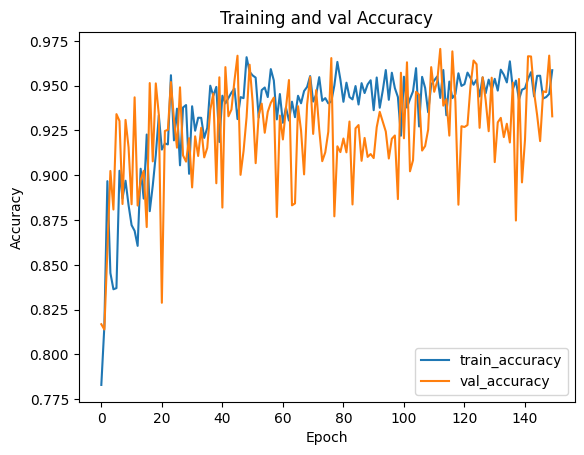

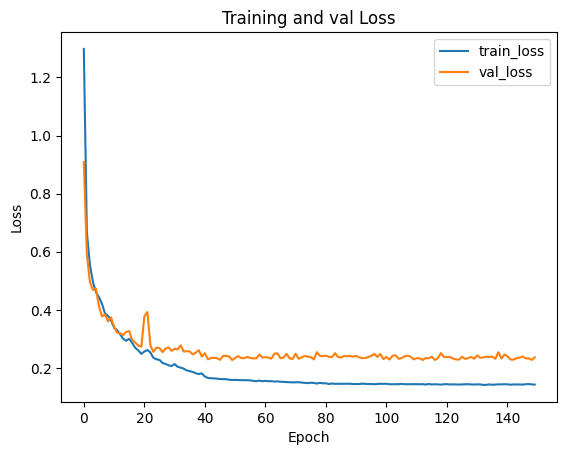

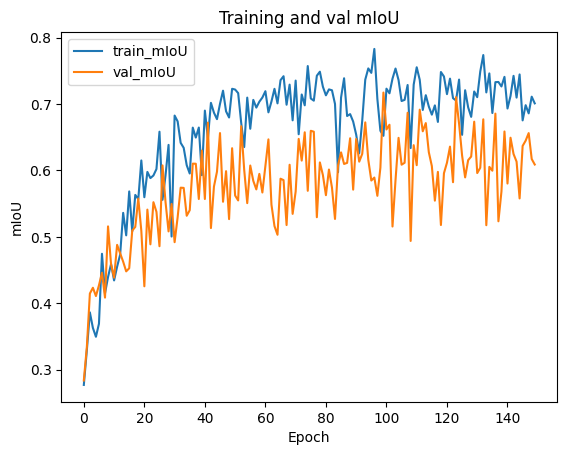

In [26]:
plt.figure()
plt.plot(train_accuracies, label="train_accuracy")
plt.plot(val_accuracies, label="val_accuracy")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and val Accuracy')

plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and val Loss')

plt.figure()
plt.plot(train_mIoUs, label="train_mIoU")
plt.plot(val_mIoUs, label="val_mIoU")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Training and val mIoU')

# Testing the Model

In [27]:
best_val_model_path = '/kaggle/working/best_val_checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint = torch.load(best_val_model_path, map_location=torch.device(device))
# Before loading the state_dict of the model, make sure the "model" instance is 
# initiated by its corresponding class e.g. VGG16
model.load_state_dict(best_val_checkpoint['model'])

<All keys matched successfully>

Calculating Metrices for Comparison and Evaluation

In [28]:
mob_miou = test_miou_score(model, test_set)
np.mean(mob_miou)

  0%|          | 0/101 [00:00<?, ?it/s]

0.6039484593744058

In [29]:
dice_score = test_dice_coefficient(model, test_set)
print(dice_score)

  0%|          | 0/101 [00:00<?, ?it/s]

1.0


In [30]:
spec = test_specificity(model,test_set)
print(spec)

  0%|          | 0/101 [00:00<?, ?it/s]

1.0


In [31]:
sensi = test_sensitivity(model, test_set)
print(sensi)

  0%|          | 0/101 [00:00<?, ?it/s]

0.9969739548050531


In [32]:
accu = test_pixel_accuracy(model, test_set)
print(accu*100)

  0%|          | 0/101 [00:00<?, ?it/s]

91.65362367535582


In [33]:
f1_sc = test_f1_score(model,test_set)
print(f1_sc)

  0%|          | 0/101 [00:00<?, ?it/s]

0.9969081801943259


16
56
17
70
52


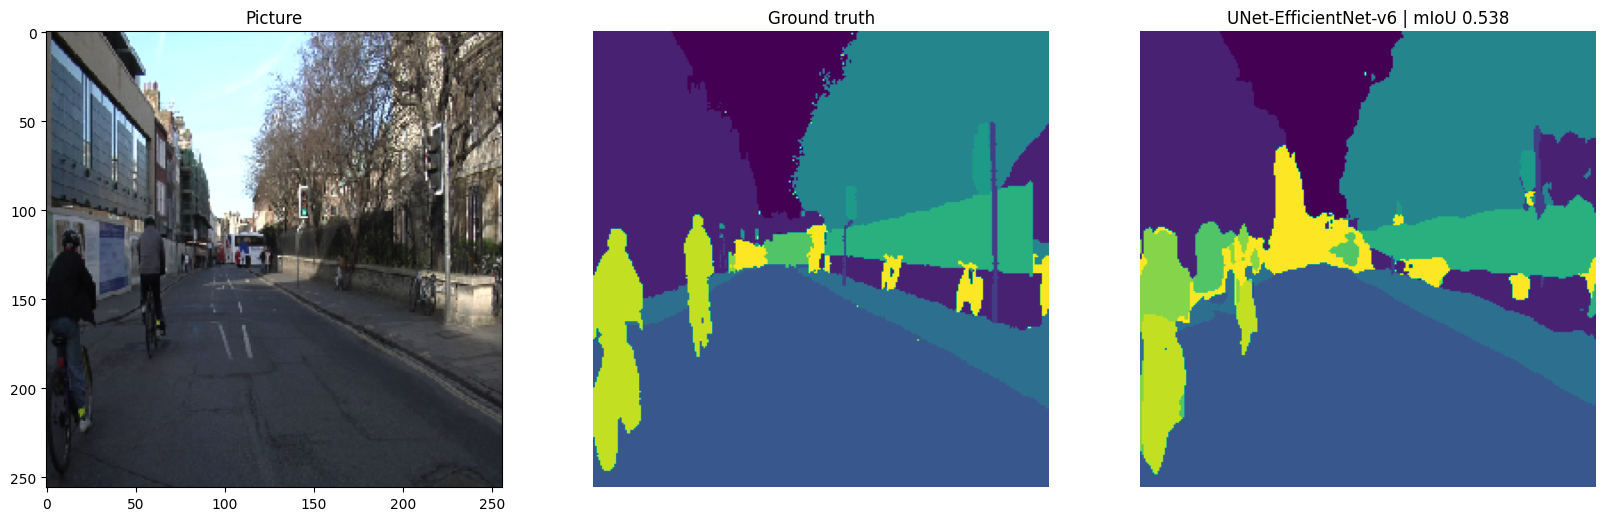

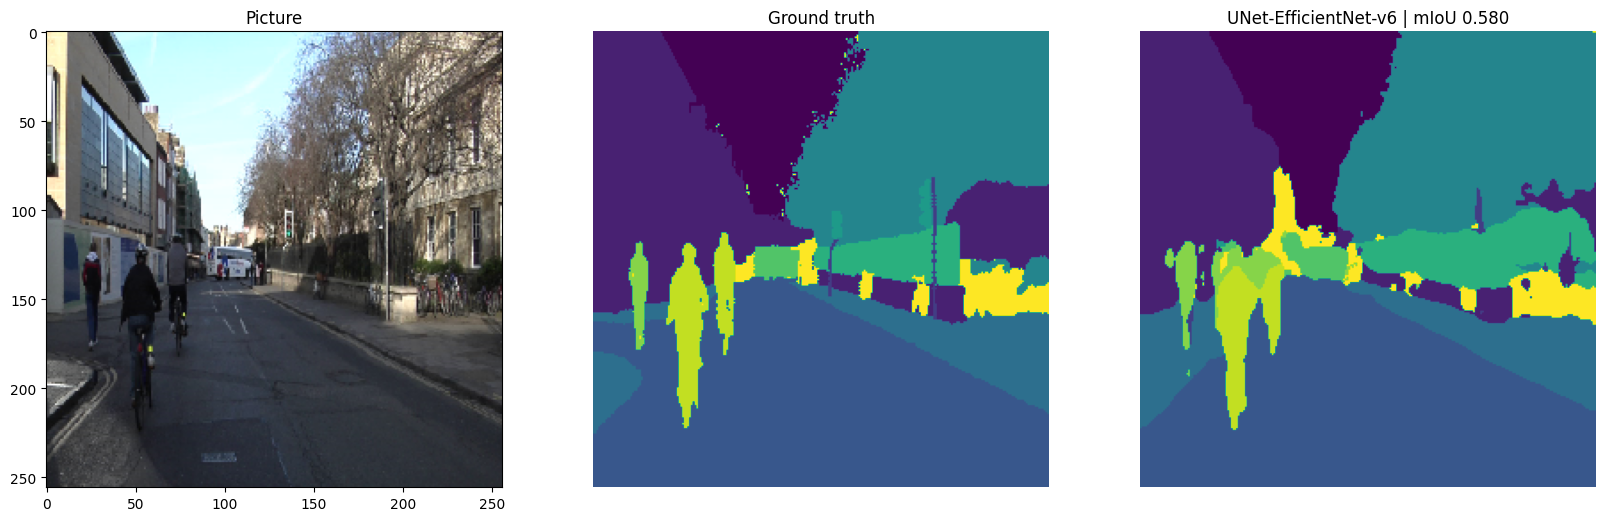

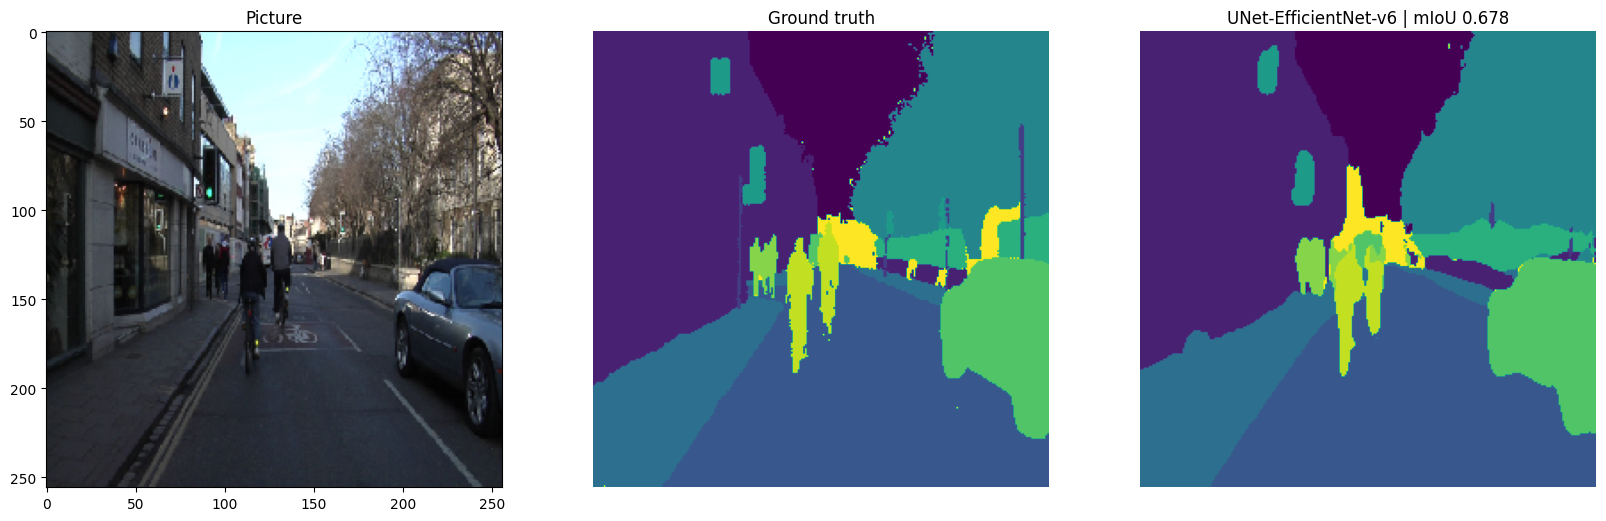

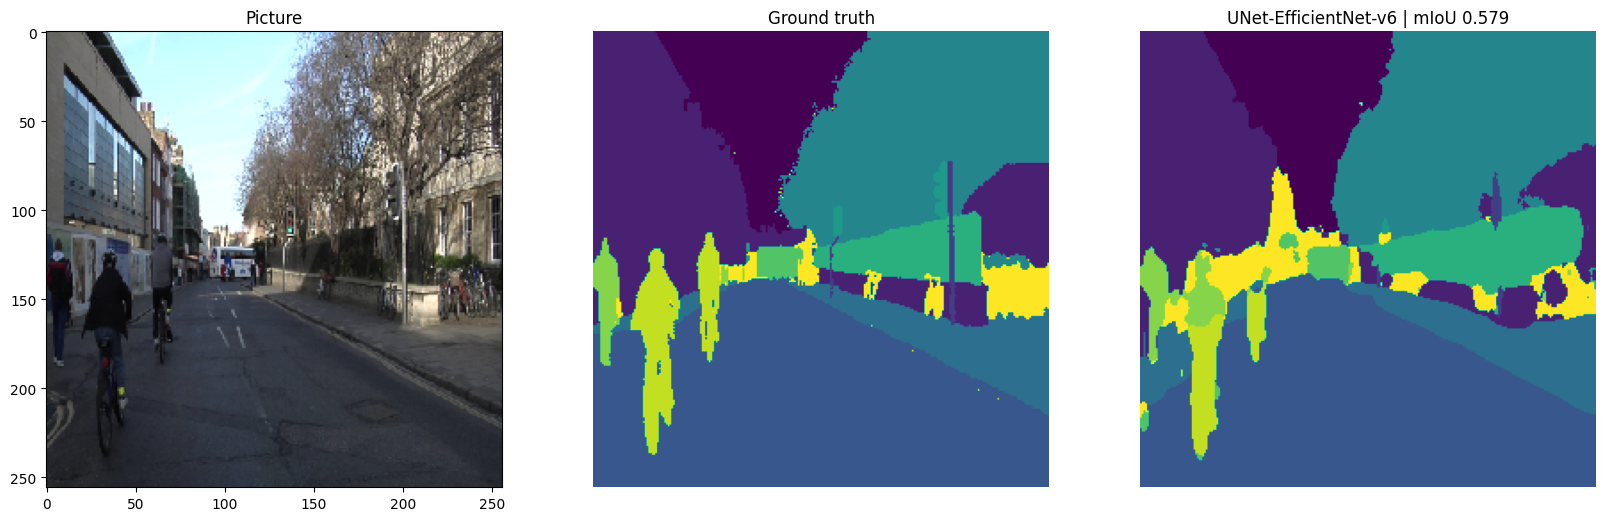

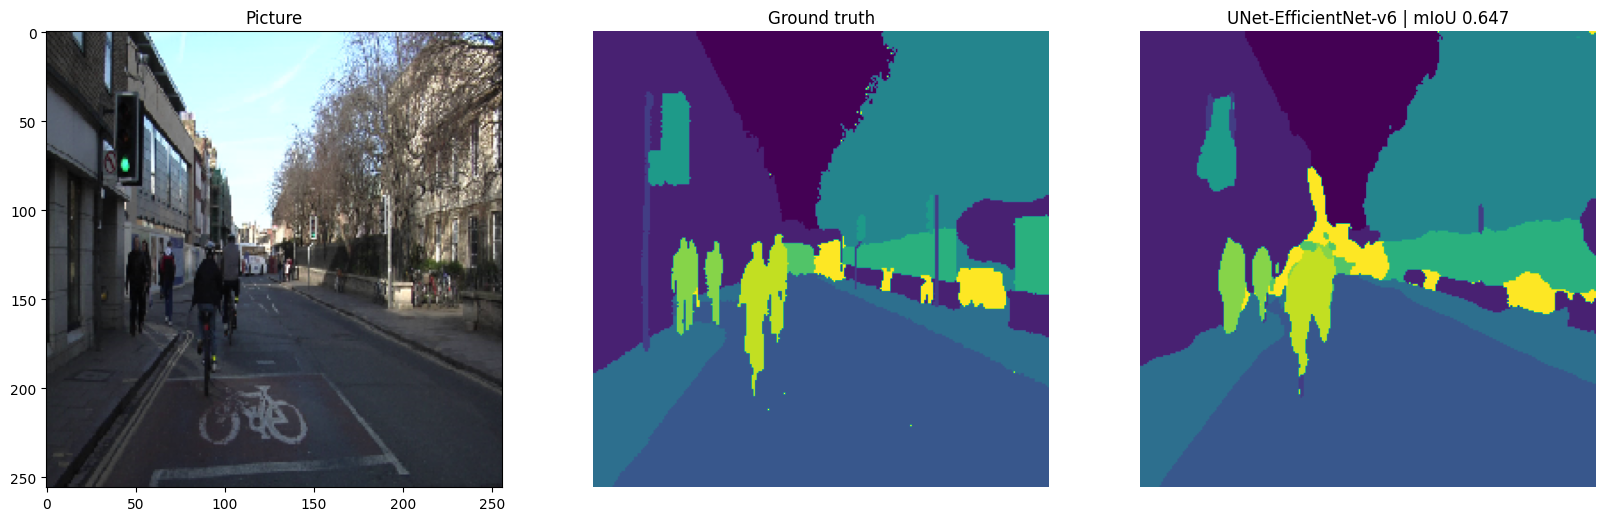

In [34]:
n = 5
ids = np.random.choice(np.arange(len(test_set)), size=n)
for i in ids:
    image, mask = test_set[i]
    pred_mask, score = predict_image_mask_miou(model, image, mask)
    display_for_comparison(image, mask, pred_mask)
    print(i)

16
56
17
70
52


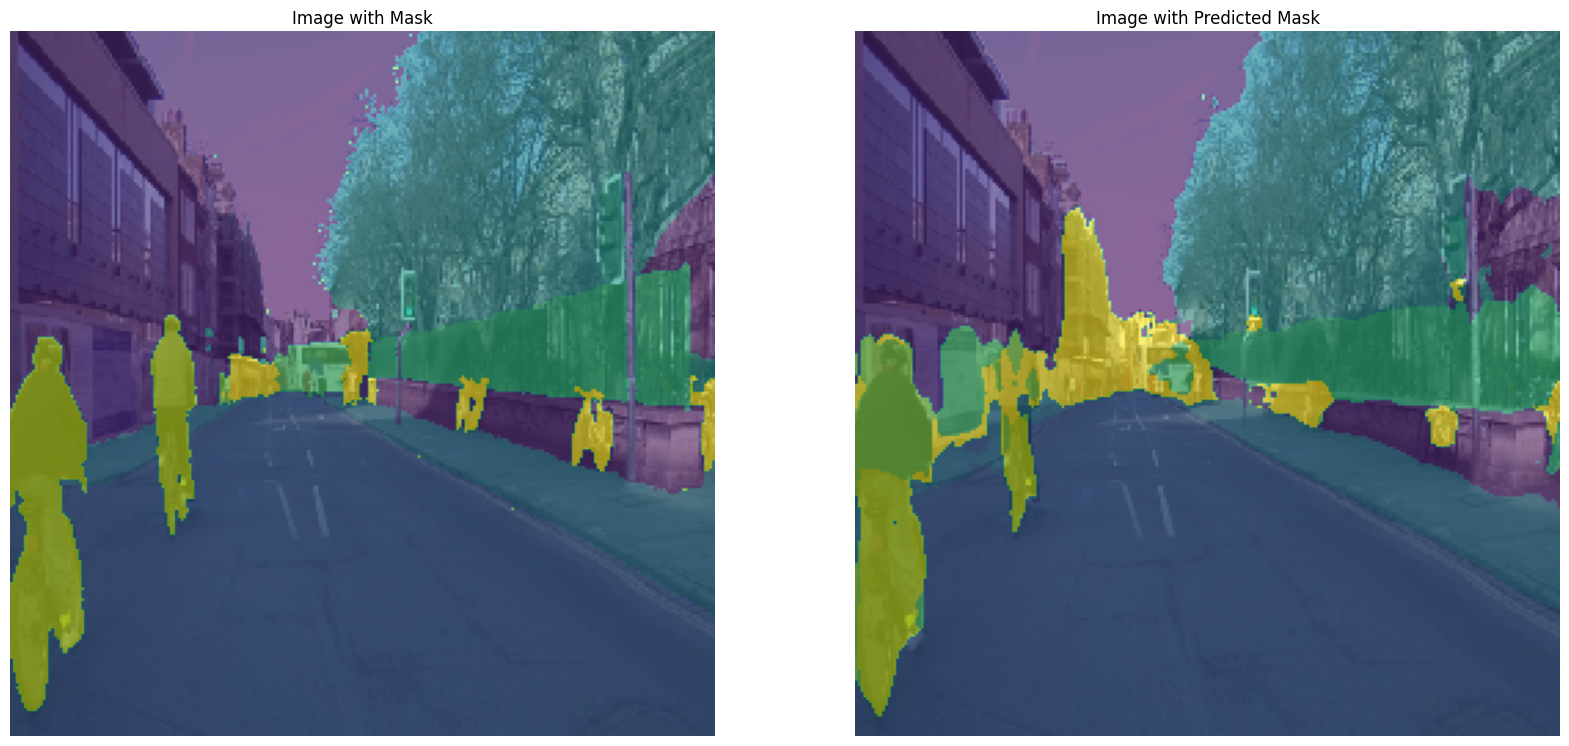

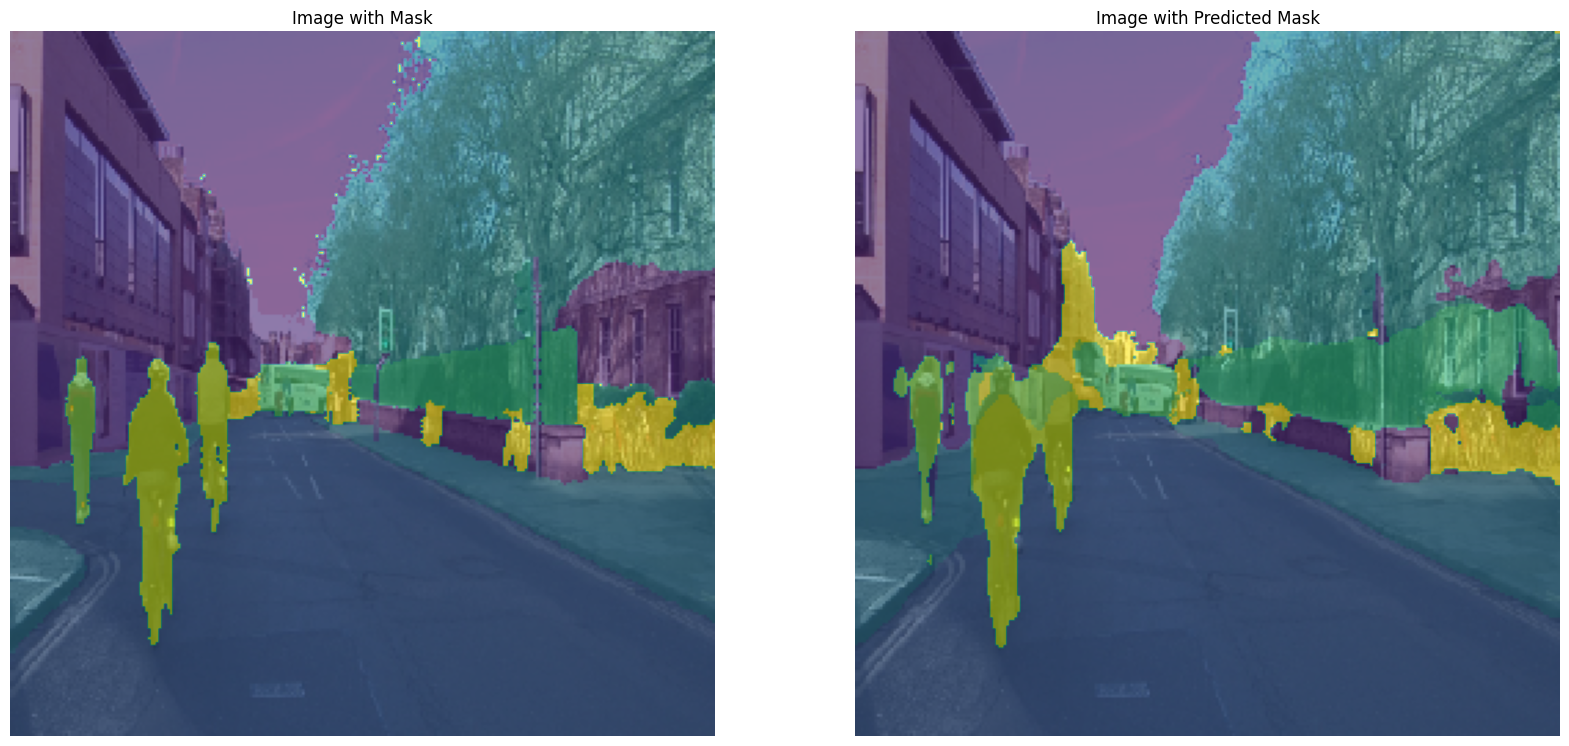

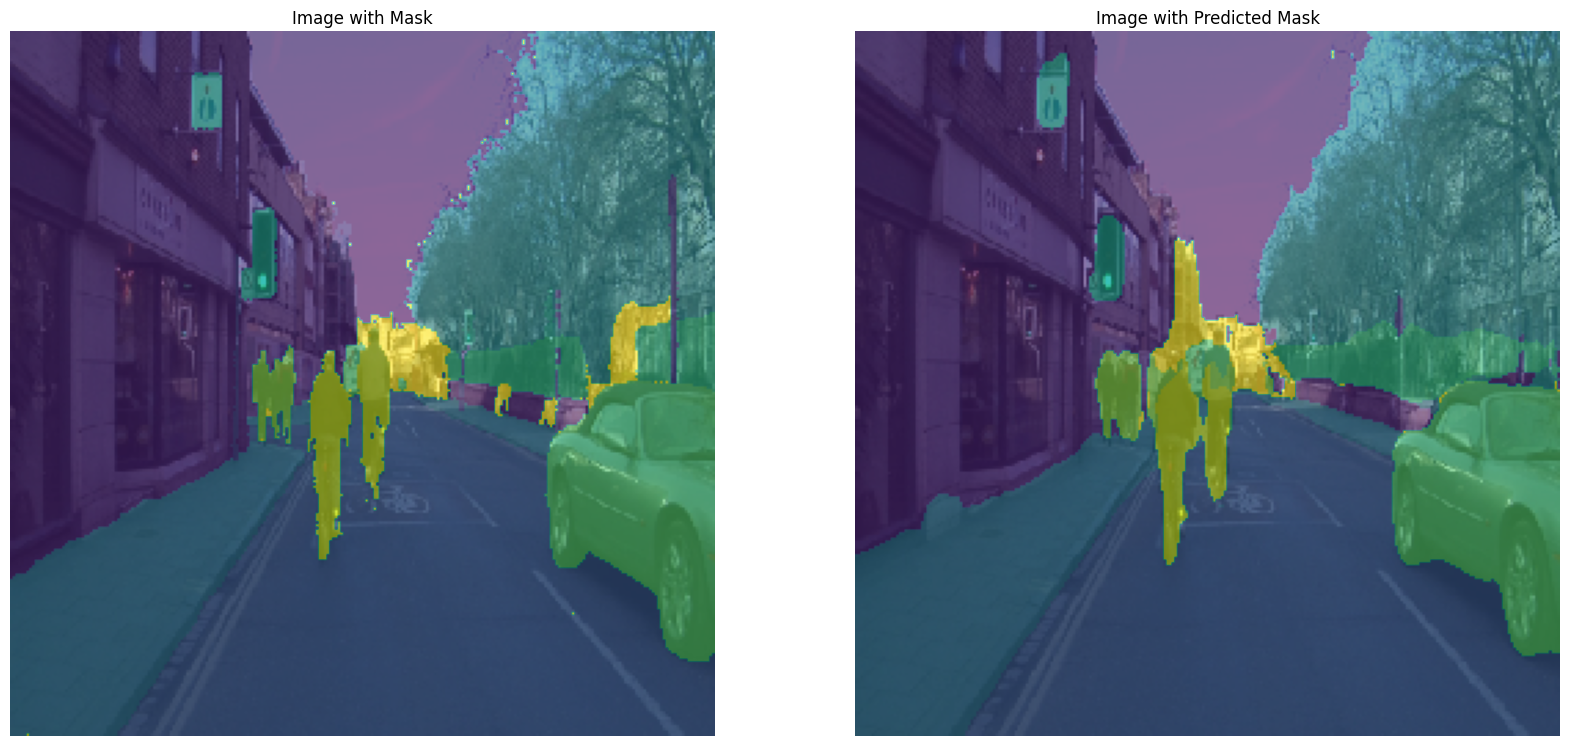

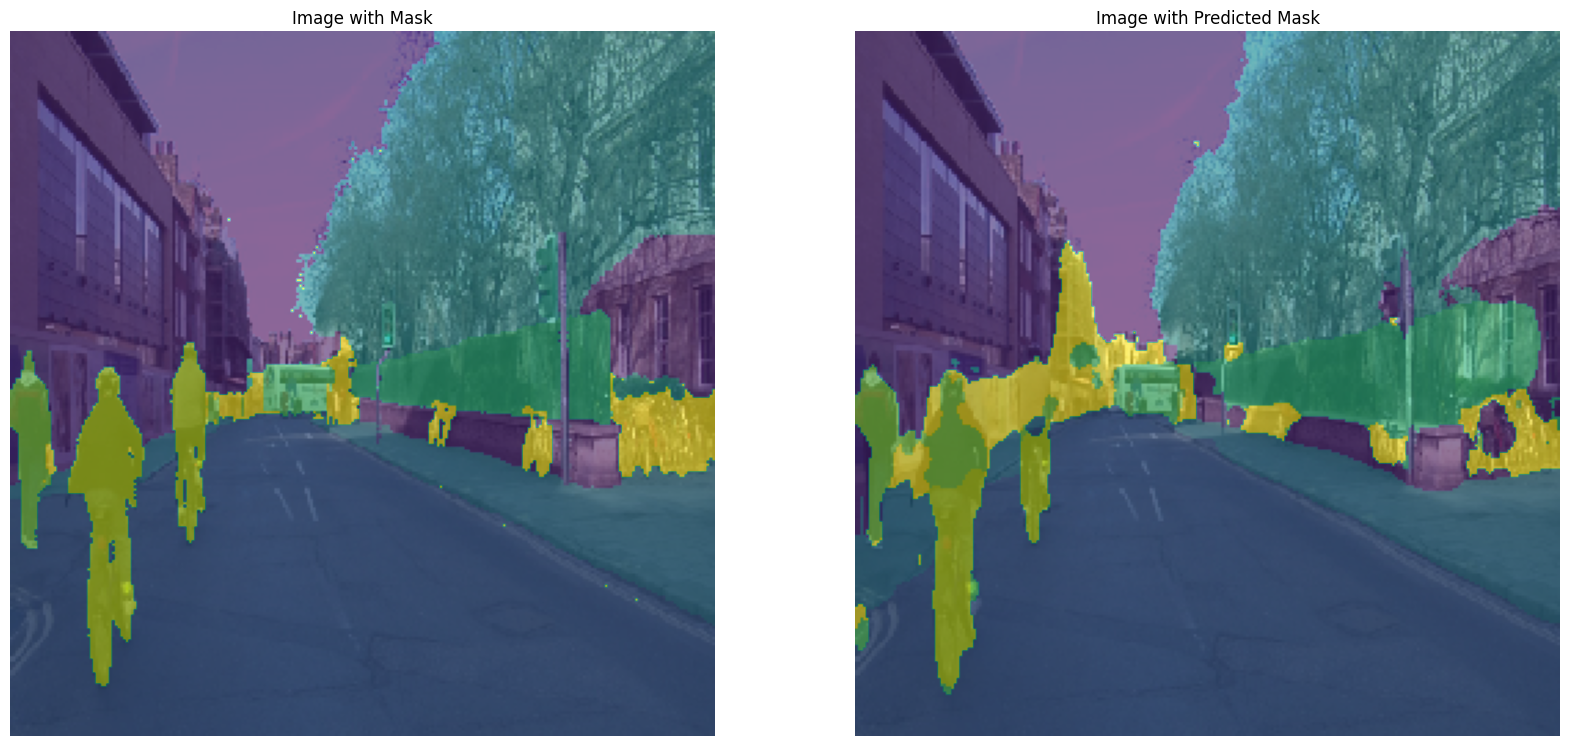

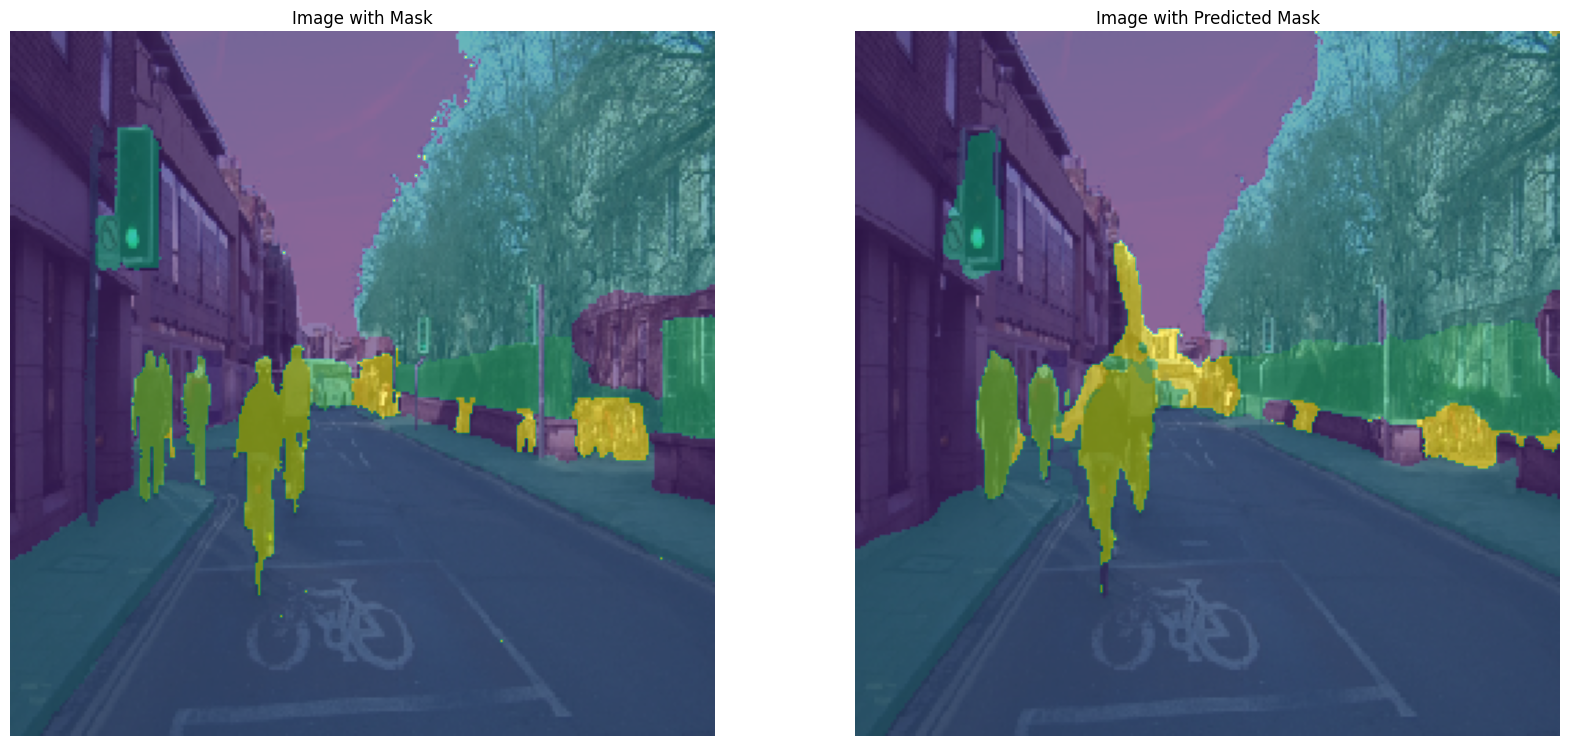

In [35]:
for i in ids:
    image, mask = test_set[i]
    pred_mask, score = predict_image_mask_miou(model, image, mask)
    display_for_comparison_with_image(image, mask, pred_mask)
    print(i)